6/21/2022

Code to test bending mode implementation.

In [1]:
using Revise

In [2]:
using MKL # should give a speed up. Check below that the MKL library actually loads. May cause error on Apple machines.
using JuliaSpectra
using Plots
using LinearAlgebra
using Parameters
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libmkl_rt.1.dylib

In [59]:
bounds = (l=[-1,1], J = 1/2:7/2, I=1/2, Σ=[-1/2,1/2], Λ=0, S = 1/2, F=0:4, M=-4:4)
basisX = enumerate_states(LinearCaseA_Bend_Field, bounds)

bounds = (l=[-1,1], J = 1/2:5/2, I=1/2, N=1:2, Λ=0, S = 1/2, F=0:4, M=-4:4)
basisX = enumerate_states(LinearCaseB_Bend_Field, bounds)
;

In [61]:
@unpack B, γ, qv, bF, c, μa = MolParams["CaOH"]["X010"]
@consts begin
    sol = 29979.2458 # converts cm-1 to MHz.
    BX = B * sol
    γX = γ * sol
    qvX = qv * sol
    bFX = bF * sol
    cX = c * sol
    μel = μa
end
;

In [95]:
Elist = range(1e-2, stop=250, length=500)

# X State
Hrot = BX * Rotation
Hsr = γX* SpinRotation
Hhf = (bFX+cX/3) * HyperfineFermi + cX * Hyperfine_Dipolar_c
Hld = qvX * lDoubling
HX0 = Hrot + Hsr + Hhf + Hld
@time eigsysX = eigenshuffle(HX0, μel*Stark, basisX, Elist, pack_eigensystem=true, warn_if_lost=true)
;

  0.812890 seconds (822.92 k allocations: 266.389 MiB, 1.90% gc time)


In [96]:
function conditions(eigsys)
    basis = eigsys[1].basis
    evecs = eigsys[1].coeffs
    parityop = build(Hamiltonian(basis=basis, H_operator = parity))
    Nlab = basis[argmax(abs2.(evecs))].N
    plab = Int64(round(evecs[:,1]' * parityop * evecs[:,1], digits=1))
    return (Nlab,plab)
end
Xinds = subspaceinds(eigsysX, conditions)

Dict{Any, Any} with 4 entries:
  (1//1, -1) => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  (1//1, 1)  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  (2//1, -1) => [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60…
  (2//1, 1)  => [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40…

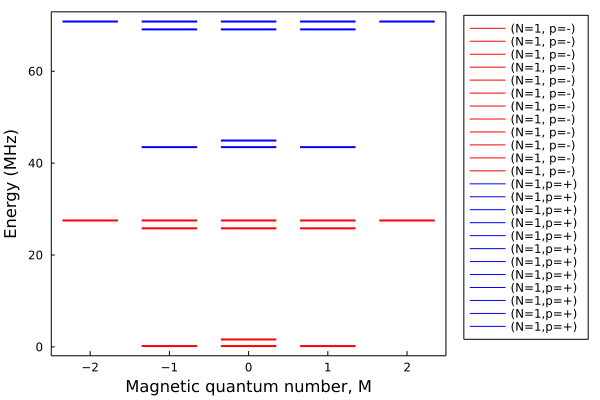

In [99]:
p=plotZeemanlevels(eigsysX[Xinds[1,-1],1], energy_offset = 9957, units="cm-1", ylabel="Energy", lw=2, color=:red, label="(N=1, p=-)")
plotZeemanlevels!(p,eigsysX[Xinds[1,1],1], energy_offset = 9957, units="cm-1",lw=2, color=:blue, label="(N=1,p=+)", legend=:outerright)
ylabel!("Energy (MHz)")

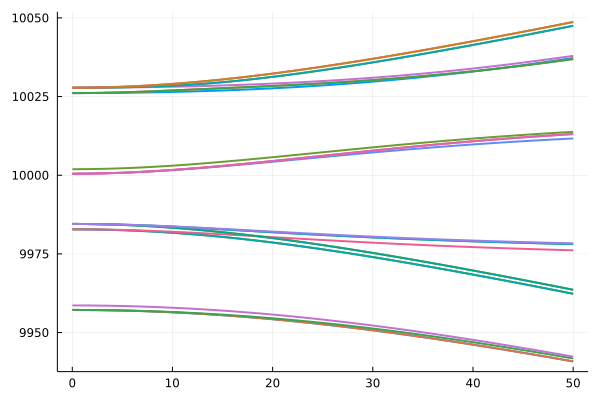

In [90]:
plot(Elist,eigsysX[1:24,:].E',legend=false, lw=2)

# A state

In the basis of Li and Coxon, using a parity case (a) basis, you get a 4x4 block for each J labeled by the basis states $ \lvert ^2\Delta_{5/2}; \pm \rangle$,  $ \lvert ^2\Delta_{3/2}; \pm \rangle$, $ \lvert \kappa ^2\Sigma; \pm \rangle$, $ \lvert \mu ^2\Sigma; \pm \rangle$, where $\pm$ refers to e/f parity. So in a non-parity basis, each $J$ should give rise to an 8x8 block.

In [8]:
bounds = (l=[-1,1], J = 9/2, I=0, Λ=[-1,1], S = 1/2, M=1/2)
basis = enumerate_states(LinearCaseA_Bend_Field, bounds)


8-element Vector{LinearCaseA_Bend_Field}:
 |Λ = -1.0, l = -1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = -1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = -1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = -0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = 1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = -1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = 1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = -0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = -1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = 0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = -1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = 1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = 1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = 0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = 1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = 1.5, I = 0.0, F = 4.5, M = 0.5>

Using the `VibronicManifold` struct to do this...

In [9]:
xstate = makevibronicmanifold(basisX, [(BX, Rotation),(γX,SpinRotation),(bFX+cX/3, HyperfineFermi),(cX,Hyperfine_Dipolar_c), (qvX, lDoubling),(0.0, μel*Stark)])

VibronicManifold{LinearCaseB_Bend_Field}(LinearCaseB_Bend_Field[|Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 0.0, M = 0.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = -1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 0.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = -1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = 0.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 1.0, M = 1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = -2.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = -1.0>, |Λ = 0.0, l = -1.0, N = 1.0, S = 0.5, J = 1.5, I = 0.5, F = 2.0, M = 0.0>  …  |Λ = 0.0, l = 1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 0.0>, |Λ = 0.0, l = 1.0, N = 1.0, S = 0.5, J = 0.5, I = 0.5, F = 1.0, M = 1.0>, |Λ = 0.0, l = 1.0, N = 1.0, S =

Make an eigenshuffle function that can act on vibronic manifolds. My idea is to have the vibronic manifold represent the "H0" part and the H1 to come from the scanned Hamiltonian term.

In [10]:
# function eigenshuffle(H0, H1, basis, params; pack_eigensystem=true, warn_if_lost=true)

  0.897225 seconds (3.76 M allocations: 252.707 MiB, 7.11% gc time, 87.23% compilation time)


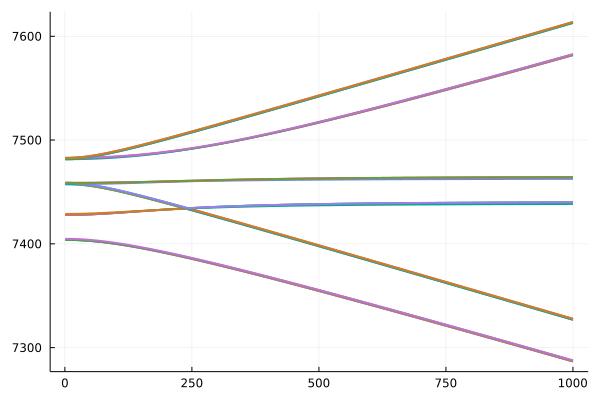

In [11]:
all_evals = []
Elist = range(1e-2, stop = 150, length = 1000)
@time for E in Elist
    xstate.prefactors[6] = E
    xb = makeblockedvibronicmanifold(xstate; block_fully = false)
    push!(all_evals, xb.evals)
end
plot(reduce(hcat,all_evals)', lw=2, legend=false)

In [13]:
xb = makeblockedvibronicmanifold(xstate; block_fully = false)

HamiltonianBlock{LinearCaseB_Bend_Field}
  basis: Array{LinearCaseB_Bend_Field}((24,))
  H: Array{Float64}((24, 24)) [7416.823013108334 0.0 … 0.0 0.0; 0.0 7510.8802353305555 … 0.0 0.0; … ; 0.0 0.0 … 7542.009549891834 0.0; 0.0 0.0 … 0.0 7613.259549891834]
  evals: Array{Float64}((24,)) [7286.705592689429, 7286.705592689433, 7287.6081851842955, 7287.652014621963, 7326.859661162962, 7326.859661162963, 7327.7558757131665, 7327.755875713168, 7438.437455935441, 7439.937622952191  …  7464.130392720214, 7464.256502584034, 7581.859760602108, 7581.85976060211, 7582.665456146283, 7582.7038489632305, 7612.87292899042, 7612.872928990421, 7613.763224070499, 7613.7632240705]
  evecs: Array{Float64}((24, 24)) [9.79598346884103e-15 2.393592323044619e-13 … 0.0 9.722927665024528e-17; -0.002121448671355639 -0.044790232541249295 … 0.0 -3.3563019560953505e-15; … ; 0.008307368589593033 -0.0003934709658090118 … 0.0 -3.142091919778605e-14; 0.0 0.0 … 0.9991190853551547 0.0]


In [ ]:
function Base.show(io::IO, state::Eigenstate)

    energy = state.E
    basis = state.basis
    coeffs = state.coeffs
    basis_type = typeof(basis[1])

    printed = false
    fields = fieldnames(basis_type)[1:end-1] # Christian has [2:end-1]... why?
    print(io,"E = "*string(round(energy,digits=6))*"\n")
    for (i,coeff) in enumerate(coeffs)
        str = ""
        basis_state = basis[i]
        if norm(coeff) > 1e-3
            plus_sign = true
            state_str = ""
            real_val = string(round(real(coeff), digits=4))
            imag_val = string(round(imag(coeff), digits=4))
            if (abs(real(coeff)) > 1e-3) && (abs(imag(coeff)) < 1e-5)
                state_str *= real_val
                if real(coeff) < 0
                    plus_sign = false
                end
            elseif (abs(imag(coeff)) > 1e-3) && abs((real(coeff)) < 1e-5)
                state_str *= imag_val * "i"
                if imag(coeff) < 0
                    plus_sign = false
                end
            else
                state_str *= "(" * real_val * " + " * imag_val * "i" * ")"
            end
            if plus_sign && printed
                str *= "+ "
            end
            str *= state_str
            str *= " "
            str *= print_basis_state(basis_state, fields)
            println(io, str)
            printed = true
        end
    end
    return nothing
end